# Packages & Functions

## Packages

In [1]:
import os
os.chdir('D:\\Gnan\\DA\\KMU\\Prediction-COVID-19')
import time
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim.adam import Adam
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from utils import *

#warnings.filterwarnings('ignore')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Functions

In [2]:
def outlier(df, col, z):
    return df[abs(df[col] - np.mean(df[col]))/np.std(df[col])>z]

In [3]:
def scailing(x, y):

    ms = MinMaxScaler()
    ss = StandardScaler()

    x_ss = ss.fit_transform(x)
    y_ms = ms.fit_transform(y)

    return x_ss, y_ms

In [4]:
def window_sliding(x, y, step):
    
    x_ws, y_ws = list(), list()
    for i in range(len(df)):
        x_end = i + step
        y_end = x_end + 1
        
        if y_end > len(df):
            break
        
        tx = x[i:x_end, :]
        ty = y[x_end:y_end, :]
        
        x_ws.append(tx)
        y_ws.append(ty)
        
    return torch.FloatTensor(x_ws).to(device), torch.FloatTensor(y_ws).to(device).view([-1, 1])

In [5]:
def plotting(train_loader, test_loader, actual):
    with torch.no_grad():
        train_pred = []
        test_pred = []

        for data in train_loader:
            seq, target = data
            out = model(seq)
            train_pred += out.cpu().numpy().tolist()

        for data in test_loader:
            seq, target = data
            out = model(seq)
            test_pred += out.cpu().numpy().tolist()
      
    total = train_pred + test_pred
    plt.figure(figsize=(20,10))
    plt.plot(np.ones(100)*len(train_pred), np.linspace(0,1,100), '--', linewidth=0.6)
    plt.plot(actual, '--')
    plt.plot(total, 'b', linewidth=0.6)

    plt.legend(['train boundary', 'actual', 'prediction'])
    plt.show()


# Data Processing

## Load Data

In [12]:
data = pd.read_csv('../../Data/CleanedData/서울_Cleaned.csv')
print(data.dtypes)

FileNotFoundError: [Errno 2] No such file or directory: '../../Data/CleanedData/서울_Cleaned.csv'

In [6]:
path = 'Data/SIR_Origin/*.csv'
dic_files = Load_files.load_files(path, -17, -15)
data = dic_files['서울']
data

,Date,City,Susceptible,Infected,Dead,Recovered,alpha,beta,gamma
0,2020-01-20,서울,9535432,0,0,0,0.000000,0.000000,0.000000
1,2020-01-21,서울,9535432,0,0,0,0.000000,0.000000,0.000000
2,2020-01-22,서울,9535432,0,0,0,0.000000,0.000000,0.000000
3,2020-01-23,서울,9535432,0,0,0,0.000000,0.000000,0.000000
4,2020-01-24,서울,9535431,1,0,0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
1167,2023-04-01,서울,3544282,25006,6383,5959761,0.258321,0.074782,0.000000
1168,2023-04-02,서울,3541881,25537,6383,5961631,0.088766,0.026980,0.000039
1169,2023-04-03,서울,3541039,25689,6384,5962320,0.376110,0.110631,0.000117
1170,2023-04-04,서울,3537451,26432,6387,5965162,0.341943,0.103019,0.000113


## Index & Col

In [7]:
df = Prepare_df.processing(data, 'Date', 'alpha')
df

,AC,DAC,DDAC
Date,,,
2020-01-22,0.000000,0.000000,0.000000
2020-01-23,0.000000,0.000000,0.000000
2020-01-24,0.000000,0.000000,0.000000
2020-01-25,0.000000,0.000000,0.000000
2020-01-26,0.000000,0.000000,0.000000
...,...,...,...
2023-04-01,0.258321,0.029674,0.075489
2023-04-02,0.088766,-0.169555,-0.199229
2023-04-03,0.376110,0.287344,0.456898


In [ ]:
df = data.loc[:, ['stdDay', 'defCnt']]
df.rename(columns = {'defCnt':'ACC', 'stdDay':'Date'}, inplace = True)
df['AC'] = df['ACC'] - df['ACC'].shift(1)
df['DAC'] = df['AC'] - df['AC'].shift(1)
df['DDAC'] = df['DAC'] - df['DAC'].shift(1)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace = True)
df = df.loc[:, ['AC', 'DAC', 'DDAC']]

In [ ]:
df.head()

## Outlier Values

In [22]:
df.describe()

,AC,DAC,DDAC
count,1170.000000,1.170000e+03,1170.000000
mean,0.118489,-3.914248e-19,-0.000292
std,0.128785,1.486782e-01,0.247432
min,0.000000,-2.250000e+00,-5.250000
25%,0.067940,-2.188079e-02,-0.026694
50%,0.094888,-5.483027e-03,0.000658
75%,0.139007,9.995145e-03,0.025989
max,3.000000,3.000000e+00,3.000000


In [23]:
outlier_list = outlier(df, 'AC', 1.58)

outlier_list.head()

,AC,DAC,DDAC
Date,,,
2020-01-29,3.000000,3.000000,3.000000
2020-01-30,0.750000,-2.250000,-5.250000
2020-02-15,0.400001,0.400001,0.400001
2020-02-18,0.333334,0.333334,0.333334
2020-02-20,1.250002,1.250002,1.583336


## Null Values

In [24]:
df.isnull().sum()

AC      0
DAC     0
DDAC    0
dtype: int64

In [25]:
df.dropna(inplace = True)
df.head()

,AC,DAC,DDAC
Date,,,
2020-01-22,0.0,0.0,0.0
2020-01-23,0.0,0.0,0.0
2020-01-24,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.0
2020-01-26,0.0,0.0,0.0


## Split Target

In [8]:
x = df.iloc[:, 0:]
y = df.iloc[:,:1]
print(x.head())
print()
print(y.head())

             AC  DAC  DDAC
Date                      
2020-01-22  0.0  0.0   0.0
2020-01-23  0.0  0.0   0.0
2020-01-24  0.0  0.0   0.0
2020-01-25  0.0  0.0   0.0
2020-01-26  0.0  0.0   0.0

             AC
Date           
2020-01-22  0.0
2020-01-23  0.0
2020-01-24  0.0
2020-01-25  0.0
2020-01-26  0.0


## Scailing

In [9]:
ms = MinMaxScaler()
ss = StandardScaler()

x_ss = ss.fit_transform(x)
y_ms = ms.fit_transform(y)

In [10]:
print(x_ss[:5])
print()
print(y_ms[:5])

[[-9.20443907e-01  2.63382442e-18  1.18167427e-03]
 [-9.20443907e-01  2.63382442e-18  1.18167427e-03]
 [-9.20443907e-01  2.63382442e-18  1.18167427e-03]
 [-9.20443907e-01  2.63382442e-18  1.18167427e-03]
 [-9.20443907e-01  2.63382442e-18  1.18167427e-03]]

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [11]:
x = x.to_numpy()
y = y.to_numpy()
x, y = window_sliding(x, y, 60)
x_ss, y_ms = window_sliding(x_ss, y_ms, 60)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_2552\928802963.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:204.)
  return torch.FloatTensor(x_ws).to(device), torch.FloatTensor(y_ws).to(device).view([-1, 1])


In [12]:
x_train = x_ss[:800]
y_train = y_ms[:800]
x_test = x_ss[800:]
y_test = y_ms[800:]
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

torch.Size([800, 60, 3])
torch.Size([800, 1])
torch.Size([310, 60, 3])
torch.Size([310, 1])


In [13]:
train = torch.utils.data.TensorDataset(x_train, y_train)
test = torch.utils.data.TensorDataset(x_test, y_test)

batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset = train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(dataset = test, batch_size = batch_size, shuffle = False)

# Model

## Define Model

In [24]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, sequence_length, num_layers, dropout, device):
        super(RNN, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size,
                          hidden_size, 
                          num_layers, 
                          batch_first = True,  
                          dropout = 0.3)
        self.fc1 = nn.Linear(hidden_size * sequence_length, 64)
        self.fc2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device)
        out, hn = self.rnn(x, h0)
        out = out.reshape(out.shape[0], -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = torch.flatten(out)
        return out.unsqueeze(-1)

In [25]:
input_size = x_ss.size(2)
num_layers = 2
hidden_size = 16
sequence_length = 60

In [26]:
model = RNN(input_size = input_size,
           hidden_size = hidden_size,
           sequence_length = sequence_length,
           num_layers = num_layers, 
           dropout = 0.3, 
           device = device).to(device)

criterion = nn.MSELoss()
lr = 1e-3
num_epochs = 10000
optimizer = Adam(model.parameters(), lr = lr)
patience = 10

## Training

In [27]:
loss_list = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0
    
    for data in train_loader:
        seq, target = data
        out = model(seq)
        loss = criterion(out, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    loss_list.append(running_loss/n)
    if (epoch+1) % 100 == 0:
        print('epoch: %d loss: %.4f'%(epoch+1, running_loss/n))
        
    if (epoch % patience == 0) & (epoch != 0):
            
            if loss_list[epoch-patience] < loss_list[epoch]:
                print('\n Early Stopping / epoch: %d loss: %.4f'%(epoch+1, running_loss/n))
                
                break


 Early Stopping / epoch: 81 loss: 0.0001


In [23]:
out.unsqueeze(-1).shape

torch.Size([32, 1])

## Visualize Loss Graph

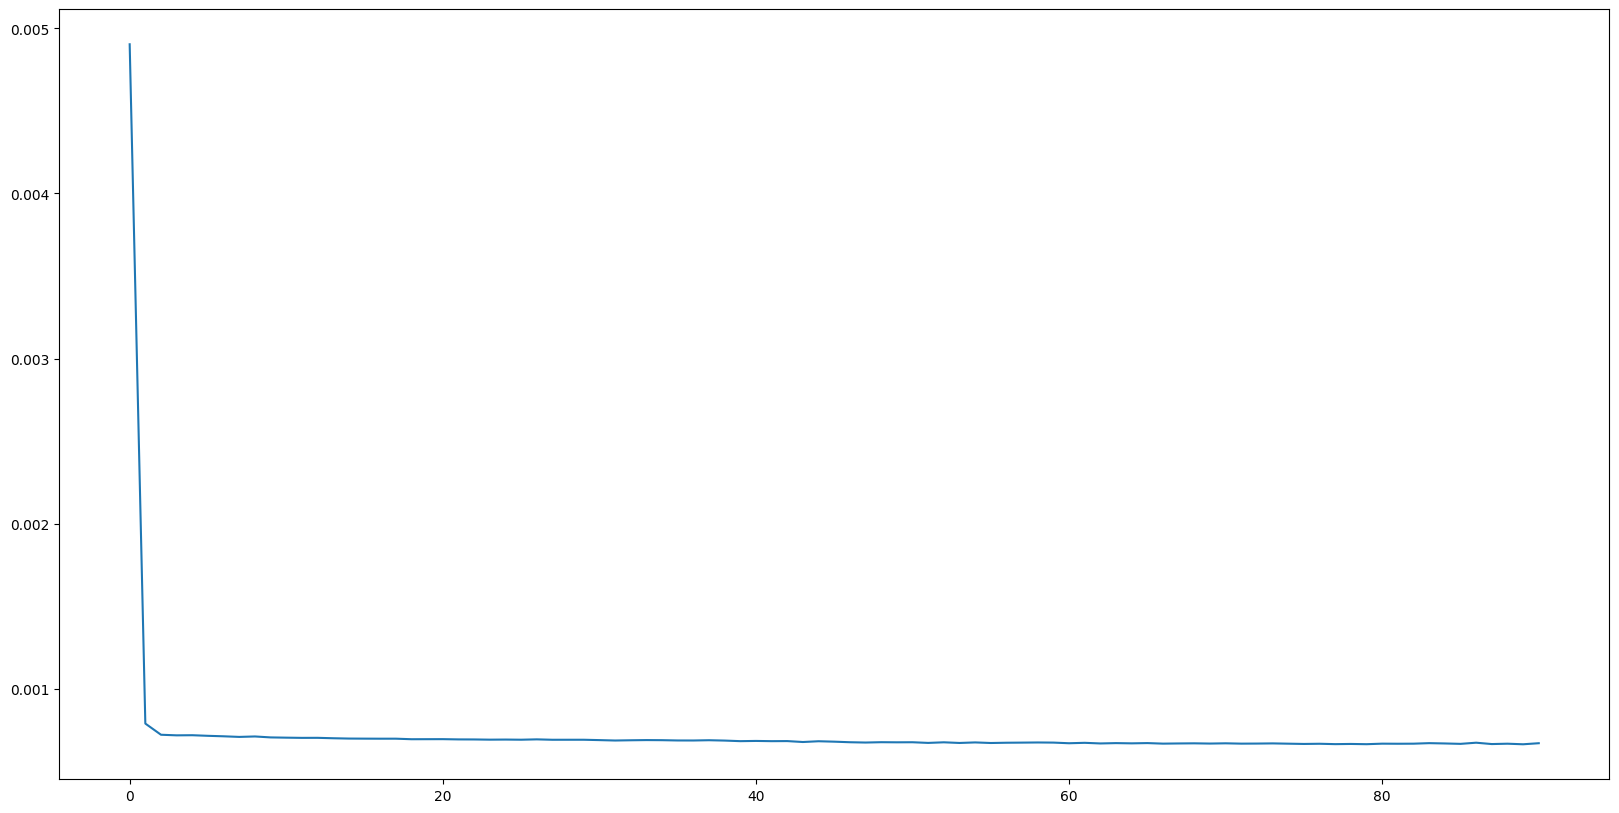

In [30]:
plt.figure(figsize = (20, 10))
plt.plot(loss_list)
plt.show()

## Model Save and Load

In [32]:
PATH = "../../model/RNN_many_to_one.pth"
torch.save(model.state_dict(), PATH)

In [33]:
PATH = "../../model/RNN_many_to_one.pth"
model = RNN(input_size = input_size,
           hidden_size = hidden_size,
           sequence_length = sequence_length,
           num_layers = num_layers,
           dropout = 0.3, 
           device = device).to(device)
model.load_state_dict(torch.load(PATH), strict=False)
model.eval()

RNN(
  (rnn): RNN(3, 16, batch_first=True, dropout=0.3)
  (fc1): Linear(in_features=960, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)

## Visualize and Compare predicted values with actual values

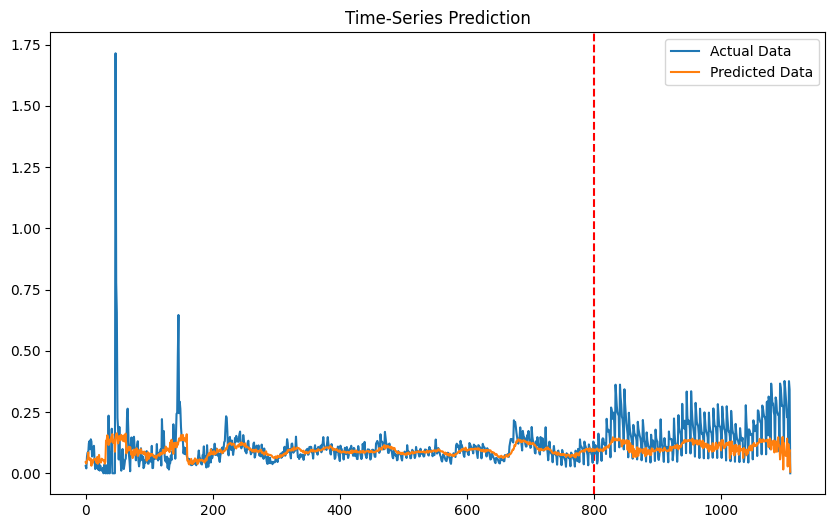

In [32]:
train_predict = model(x_ss)
predicted = train_predict.cpu().data.numpy()
label_y = y_ms.cpu().data.numpy()

predicted = predicted.reshape(1110, 1)
predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)

plt.figure(figsize = (10, 6))
plt.axvline(x = 800, c = 'r', linestyle = '--')

plt.plot(label_y, label = 'Actual Data')
plt.plot(predicted, label = 'Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

## Calculate MAE, RMSE, MAPE

In [36]:
def MAE(true, pred):
    return np.mean(np.abs(true-pred))
def RMSE(true, pred):
    return np.mean((true-pred)**2)**(1/2)
def MAPE(true, pred):
    return 100 * np.mean(np.abs((true-pred)/true))

print('MAE SCORE : ', MAE(predicted, label_y))
print('RMSE SCORE : ', RMSE(predicted, label_y))
print('MAPE SCORE : ', MAPE(predicted, label_y))

MAE SCORE :  3371.726
RMSE SCORE :  5686.66897225432
MAPE SCORE :  118.44719648361206


# Predict

## Predict more values

In [37]:
pre_ori_df = torch.zeros(1, 60, 3)
pre_ori_df[0] = x[-1]
val7 = [10000, 12000, 18000, 30000, 38000, 60000, 120000]
pre7 = []

for i in range(len(val7)):
    pre_ori_df[0][:-1] = pre_ori_df[0][1:].clone()
    pre_ori_df[0][-1][0] = val7[i]
    pre_ori_df[0][-1][1] = pre_ori_df[0][-1][0] - pre_ori_df[0][-2][0]
    pre_ori_df[0][-1][2] = pre_ori_df[0][-1][1] - pre_ori_df[0][-2][1]
    
    pre_ms_df = pre_ori_df.reshape(-1, 1)
    pre_ms_df = ms.transform(pre_ms_df).reshape(1, 60, 3)
    
    pre_ms_value = model(torch.FloatTensor(pre_ms_df).to(device))
    pre_ms_value = pre_ms_value.cpu().detach().numpy().reshape(-1, 1)
    pre_ori_value = ms.inverse_transform(pre_ms_value)

    pre7.append(pre_ori_value[0][0])

print(pre7) 

pre7 = np.array(pre7).reshape(-1, 1)
predicted_final = np.vstack((predicted, pre7))
label_y_final = np.vstack((label_y, np.array(val7).reshape(-1, 1)))

[6797.6006, 6771.5527, 7042.5156, 7225.756, 7379.3906, 7991.544, 9024.457]


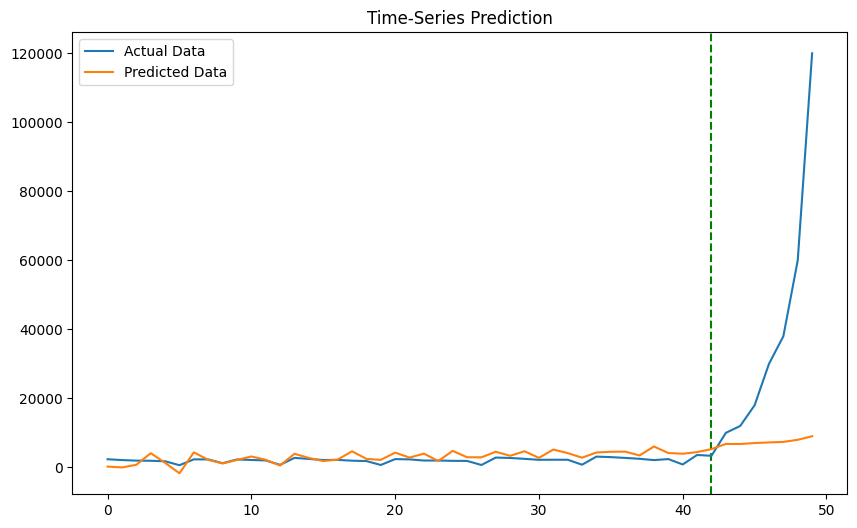

In [38]:
plt.figure(figsize = (10, 6)) 
plt.axvline(x = 42, c = 'g', linestyle = '--')

plt.plot(label_y_final[-50:], label = 'Actual Data')
plt.plot(predicted_final[-50:], label = 'Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

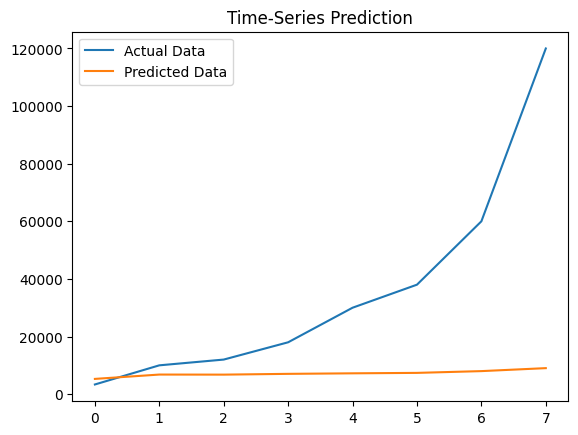

In [39]:
plt.plot(label_y_final[-8:], label = 'Actual Data')
plt.plot(predicted_final[-8:], label = 'Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()